In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.image.preprocessing import ImageDataGenerator, 
import random
from progressbar import ProgressBar
from matplotlib import pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator, load_img

In [2]:
def detect_xyr(image, min_radius_ratio=.33, max_radius_ratio=.6):
    width = image.shape[1]
    height = image.shape[0]
    myMinWidthHeight = min(width, height) 
    myMinRadius = round(myMinWidthHeight * min_radius_ratio)
    myMaxRadius = round(myMinWidthHeight * max_radius_ratio)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, minDist=450, 
                               param1=120, param2=32,
                               minRadius=myMinRadius,
                               maxRadius=myMaxRadius)
    (x, y, r) = (0, 0, 0)
    found_circle = False
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        if (circles is not None) and (len(circles == 1)):
            x1, y1, r1 = circles[0]
            if (2 / 5 * width) < x1 < (3 / 5 * width) and (2 / 5 * height) < y1 < (3 / 5 * height):
                x, y, r = circles[0]
                found_circle = True
    if not found_circle:
        x = img.shape[1] // 2
        y = img.shape[0] // 2
        temp_x = image[int(image.shape[0] / 2), :, :].sum(1)
        r = int((temp_x > temp_x.mean() / 12).sum() / 2)
    return (x, y, r)


def center_eye_bulb(image, x, y, r):
    (image_height, image_width) = (image.shape[0], image.shape[1])
    image_left = int(max(0, x - r ))
    image_right = int(min(x + r, image_width - 1))
    image_top = int(max(0, y - r))
    image_bottom = int(min(y + r, image_height - 1))
    image= image[image_top: image_bottom, image_left:image_right, :]
    return image


def set_eyebulb_diameter(image, diameter):
    if image.shape[1]>image.shape[0]:
        image = cv2.resize(image, (diameter, int(diameter*image.shape[0]/image.shape[1])))
    else:
        image = cv2.resize(image, (int(diameter*image.shape[1]/image.shape[0]), diameter))
    return image


def substract_local_average(image, filter_size, diameter):
    b=np.zeros(image.shape)
    cv2.circle(b,(image.shape[1]//2,image.shape[0]//2),int(diameter//2*0.9),(1,1,1),-1,8,0)
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), filter_size),-4, 128)*b+128*(1-b)
    #image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), filter_size),-4, 128)
    return image


def crop(image, x, y, r, percentage):
    r = int(percentage*r)
    height, width, _ = image.shape
    mask = np.zeros((height, width, 3), np.uint8)
    mask = cv2.circle(mask, (x,y), r, (1,1,1), -1)
    #mask = cv2.circle(mask, (x,y), r, (255, 255, 255), -1)
    return np.multiply(image, mask)
    #return cv2.bitwise_and()


def add_padding(image):
    (image_height, image_width) = (image.shape[0], image.shape[1])
    left_padding = 0 if image_width>image_height else (image_height-image_width)//2
    right_padding = 0 if image_width>image_height else (image_height-image_width)//2
    top_padding = 0 if image_width<image_height else (image_width-image_height)//2
    bottom_padding = 0 if image_width<image_height else int(image_width-image_height)//2
    image = cv2.copyMakeBorder(image,top=top_padding,bottom=bottom_padding, left=left_padding,right=right_padding,
                               borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return image


def preprocess(image, desired_size=540, diameter=540, filter_size=9, percentage=.9, remove=30):
    assert 2*remove<=desired_size
    (x, y, r) = detect_xyr(image.copy())
    image = center_eye_bulb(image, x, y, r)
    image = set_eyebulb_diameter(image, diameter)
    image = substract_local_average(image, filter_size, diameter)
    image = crop(image, image.shape[1]//2, image.shape[0]//2,max(image.shape[1]//2, image.shape[0]//2), percentage)
    image = add_padding(image)
    image = cv2.resize(image, (desired_size, desired_size), interpolation=cv2.INTER_NEAREST)
    #image = image[remove:desired_size-remove,remove:desired_size-remove, : ]
    return image


def preprocess_original(image, scale=540):
    x=image[image.shape[0]//2,:,:].sum(1)
    r=(x>x.mean()/10).sum()/2
    s=scale*1.0/r
    image = cv2.resize(image,(0,0),fx=s,fy=s)
    b=np.zeros(image.shape)
    cv2.circle(b,(image.shape[1]//2,image.shape[0]//2),int(scale*0.9),(1,1,1),-1,8,0)
    image=cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0),scale/30),-4,128)*b+128*(1-b)
    return image

In [3]:
db_folder = os.path.join(os.getcwd(), '../DR Databases/Kaggle')
images_folder = os.path.join(db_folder, "images")
images_preprocessed_folder = os.path.join(db_folder, "preprocessed images")
images_preprocessed_old_folder = os.path.join(db_folder, "preprocessed images (viejas)")
name_train_image = random.choice(os.listdir(images_folder))
#name_train_image = "13_left.jpeg"
random_train_image = os.path.join(images_folder, name_train_image)
random_train_preprecessed_image = os.path.join(images_preprocessed_folder, name_train_image)
random_train_preprecessed_image_old = os.path.join(images_preprocessed_old_folder, name_train_image)
print("Random image:", random_train_image.split("/")[-1])
preprocessed_folder_kaggle = os.path.join(db_folder, "preprocessed images (original)")

Random image: 24453_left.jpeg


<Figure size 432x288 with 0 Axes>

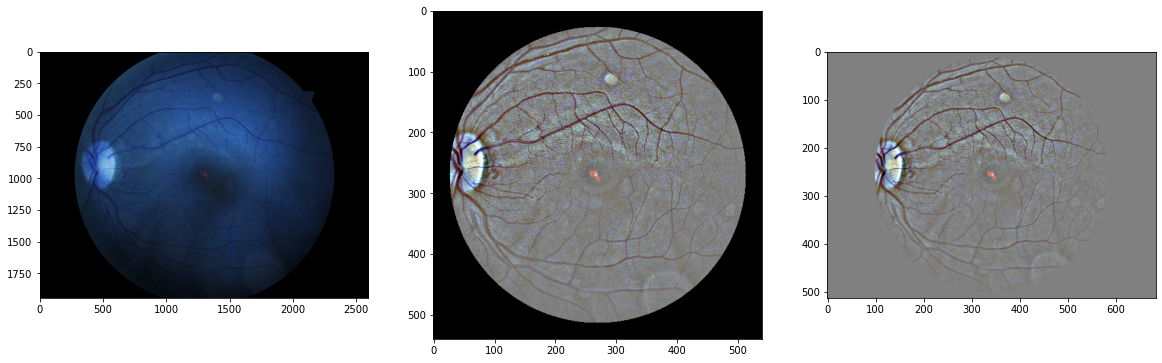

In [10]:
img = cv2.cvtColor(cv2.imread(random_train_image), cv2.COLOR_BGR2RGB)
#img = cv2.imread(random_train_image)
#img = cv2.cvtColor(cv2.imread(random_train_image, -1), cv2.COLOR_BGR2RGB)
size_image = 270
final_img = preprocess(img.copy())
cv2.imwrite(db_folder+"/WTF1.jpeg", final_img)
final_img_org = preprocess_original(img.copy(), scale=size_image)
plt.figure()
f, axarr = plt.subplots(1,3, figsize=(20,40))
axarr[0].imshow(img)
axarr[1].imshow(final_img.astype(np.uint8))
axarr[2].imshow(final_img_org.astype(np.uint8))

/home/juandavidserrano/nvme/Tesis/Scripts/../DR Databases/Kaggle/preprocessed images/24453_left.jpeg -1


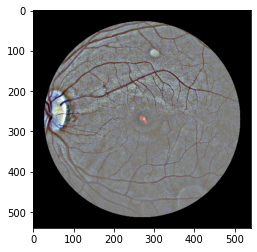

In [7]:
img_preprocessed = cv2.cvtColor(cv2.imread(random_train_preprecessed_image), cv2.COLOR_BGR2RGB)
plt.imshow(img_preprocessed)

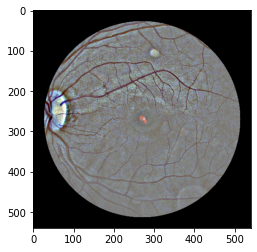

In [6]:
plt.imshow(load_img(random_train_preprecessed_image))

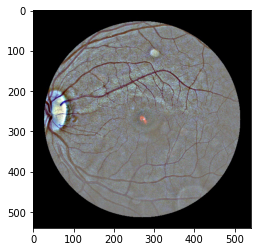

In [8]:
plt.imshow(load_img(random_train_preprecessed_image_old))